# Анализ юнит-экономики и причин стагнации выручки в контентном приложении

## Контекст
Анализируется развлекательное мобильное приложение, предоставляющее пользователям доступ к видео, подкастам и блогам по  
подписке.

## Проблема
Несмотря на рост аудитории после запуска нового спортивного контента и изменения маркетинговой стратегии,  
**выручка продукта начала стагнировать**. Бизнес-модель предполагает окупаемость привлечения пользователей за 28 дней,  
но этот показатель перестал выполняться.

## Гипотеза
Основная гипотеза заключается в том, что скорректированная маркетинговая стратегия, направленная на привлечение новой  
аудитории, привела к росту стоимости привлечения (CAC), который не был скомпенсирован ростом жизненной ценности (LTV) 
новых когорт.

## Цель исследования
1.  Провести анализ юнит-экономики продукта в динамике за первые 28 дней "жизни" когорт.
2.  Выявить причины стагнации выручки.
3.  Определить, какие маркетинговые каналы являются прибыльными, а какие - убыточными.
4.  Сформулировать рекомендации для отдела маркетинга по оптимизации затрат.


## Этапы работы
- 1. Загрузка и предобработка данных  
- 2. Подготовка данных для когортного анализа  
- 3. Анализ общих метрик продукта  
    - 3.1. Анализ метрик вовлеченности (DAU, MAU, Stickiness)  
    - 3.2. Анализ юнит-экономики по месячным когортам (период 28 дней)  
- 4. Анализ в разрезе маркетинговых каналов  
    - 4.1. Анализ объемов привлечения по каналам  
    - 4.2. Анализ метрик вовлеченности по каналам  
    - 4.3. Анализ удержания и конверсии по каналам  
    - 4.4. Анализ юнит-экономики по каналам (28 дней)  
- 5. Анализ периода окупаемости для убыточных каналов  
- 6. Выводы и рекомендации  



## Описание данных
Для анализа использовались три датасета: информация о визитах пользователей (**visits.csv**), их покупках (**orders.csv**)   
и затратах на маркетинг (**costs.csv**). Исследование охватывает пользователей, привлеченных с 1 апреля 2024 года по 30  
ноября 2024 года

1. Датасет **visits.csv** - информация о посещениях
    - `user_id` - уникальный идентификатор пользователя;
    - `region` - страна пользователя;
    - `device` - категория устройства пользователя;
    - `channel` - идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` - дата и время начала сессии;
    - `session_end` - дата и время окончания сессии.

2. Датасет **orders.csv** - информация о покупках
    - `user_id` - уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` - дата и время покупки;
    - `revenue` - выручка.

3. Датасет **costs.csv** - информация о затратах на маркетинг:
    - `dt` - дата
    - `channel` - идентификатор рекламного источника;
    - `costs` - затраты на этот рекламный источник в этот день.


In [1]:
# Устанавливаем необходимые библиотеки (--upgrade). Обновим numba чтобы убрать конфликт (numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 2.0.2)
%pip install pandas numpy scipy matplotlib seaborn ipython statsmodels matplotlib_venn tabulate pyarrow requests numba -q -U

Note: you may need to restart the kernel to use updated packages.


In [2]:
#-----------------------------------------------------------------------------
#  Импортируем библиотеки
#-----------------------------------------------------------------------------

# Работа с данными
import pandas as pd
# import numpy as np

# Визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns

# Вспомогательные импорты
from IPython.display import Markdown, display, HTML
import io

In [3]:
# Стили и настройки форматирования
display(HTML("""<style>.output_area{max-height: none !important;}
             h1{color:#D14D41;}h2{color:#DA702C;}h3{color:#D0A215;}
             h4{color:#879A39;}h5{color:#3AA99F;}h6{color:#4385BE;}
             </style>"""))

In [4]:
#-----------------------------------------------------------------------------
# Полезные функции
#-----------------------------------------------------------------------------


# ------------------------------------------------------------------------------
# Расширенная информация о данных
# выводит процент нулей, чтобы не прикидывать в уме сколько там нулей? 
# 4.73% или 8.19%?🤔 Это уже достаточно много чтобы не игнорировать или еще нет?
def extended_info(df):
    buf = io.StringIO()
    df.info(buf=buf)
    info_lines = buf.getvalue().splitlines()
    rn = info_lines[1].split()[1] # rows number
    
    cols = ['Name',  'Non-Null', 'Null', 'Null share', 'Dtype']

    data = [
        [' '.join(x[1:-3]), x[-3], int(rn) - int(x[-3]), 
         f'{round((int(rn) - int(x[-3]))*100 / int(rn) , 2)}%',  x[-1]]
        for row in info_lines[5:-2]
        for x in [row.split()]
    ]
    
    meta = [
        [f'**{x[0]}**', f'**{x[1]}**'] + ['']*(len(cols)-2) 
        for row  in info_lines[-2:] 
        for x  in [row.split(': ')]
    ]
    
    data += meta
    return Markdown(pd.DataFrame(data, columns=cols).to_markdown())
     
# ------------------------------------------------------------------------------
# уникальные значения категориальных признаков
# решает проблему неявного дублирования данных. 
# - Пример вывели уники в поле город   
#     Санкт-Петербург  
#     Санкт Петербург (без дефиса)  
#     Санкт-Петербуг (опечатка)  
#     СПб (аббревиатура)  
# - сразу видно что есть неявные дубликаты  
# - **удобно**: ввел все кат. столбцы - получил на выходе уникальные значения 
# **сразу по ВСЕМ столбцам в одной таблице**
def get_df_unique_values(df, cols=None, row_count=20, _sorted=True):
    new_cols = dict()
    
    if cols is None:
        cols = df.columns.tolist()
    
    for col in cols:
        u_vals = sorted(df[col].unique()) if _sorted else df[col].unique()
        
        if len(u_vals) > row_count:
            for i in range(0, len(u_vals), row_count):
                col_name = f"{col}_{i // row_count + 1}"  
                
                chnk = pd.Series(u_vals[i:i + row_count]).reset_index(drop=True)
                padded = chnk.reindex(range(row_count), fill_value='')
                
                new_cols[col_name] = padded
        else:
            padded = pd.Series(u_vals).reindex(range(row_count), fill_value='')
            new_cols[col] = padded.reset_index(drop=True)
            
    new_df = pd.DataFrame(new_cols)
    return new_df

## 1. Загрузка и предобработка данных

> **Загрузка данных**
>
> Исходные данные были загружены из трех CSV-файлов:
> - visits.csv
> - orders.csv
> - costs.csv  
>
> и сохранены в словарь `ds` с ключами `visits`, `orders` и `costs`
>
> ⚠️*Примечание: в соответствии с политикой конфиденциальности, код загрузки и сами файлы данных удалены из публичной*  
*версии проекта*

In [6]:
# Выводим расширенную информацию о данных
for k,v in data.items():
    display(Markdown(f'#### {k}'))
    display(extended_info(v))
    # print(v.info())
    display(v.head())

#### visits

|    | Name             | Non-Null                | Null   | Null share   | Dtype   |
|---:|:-----------------|:------------------------|:-------|:-------------|:--------|
|  0 | user_id          | 161865                  | 0      | 0.0%         | int64   |
|  1 | region           | 161865                  | 0      | 0.0%         | object  |
|  2 | device           | 161865                  | 0      | 0.0%         | object  |
|  3 | channel          | 161865                  | 0      | 0.0%         | object  |
|  4 | session_start    | 161865                  | 0      | 0.0%         | object  |
|  5 | session_end      | 161865                  | 0      | 0.0%         | object  |
|  6 | **dtypes**       | **int64(1), object(5)** |        |              |         |
|  7 | **memory usage** | **7.4+ MB**             |        |              |         |

,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00


#### orders

|    | Name             | Non-Null                            | Null   | Null share   | Dtype   |
|---:|:-----------------|:------------------------------------|:-------|:-------------|:--------|
|  0 | user_id          | 33893                               | 0      | 0.0%         | int64   |
|  1 | event_dt         | 33893                               | 0      | 0.0%         | object  |
|  2 | revenue          | 33893                               | 0      | 0.0%         | float64 |
|  3 | **dtypes**       | **float64(1), int64(1), object(1)** |        |              |         |
|  4 | **memory usage** | **794.5+ KB**                       |        |              |         |

,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99


#### costs

|    | Name             | Non-Null                  | Null   | Null share   | Dtype   |
|---:|:-----------------|:--------------------------|:-------|:-------------|:--------|
|  0 | dt               | 976                       | 0      | 0.0%         | object  |
|  1 | channel          | 976                       | 0      | 0.0%         | object  |
|  2 | costs            | 976                       | 0      | 0.0%         | float64 |
|  3 | **dtypes**       | **float64(1), object(2)** |        |              |         |
|  4 | **memory usage** | **23.0+ KB**              |        |              |         |

,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


#### Первичные выводы о предоставленных данных.
- visits
    - пропусков нет
    - данные, в основном, представлены в удобном формате
    - можно преобразовать поля `session_start`, `session_end` в тип **datetime**
    - комбинация уникальных ключей `user_id`, `device`, `session_start`, `session_end`
- orders
    - пропусков нет
    - данные, в основном, представлены в удобном формате
    - можно преобразовать `event_dt` в тип **datetime**
    - комбинация уникальных ключей `user_id`, `event_dt`
- costs
    - пропусков нет
    - данные, в основном, представлены в удобном формате
    - можно преобразовать `dt` в тип **datetime**
    - комбинация уникальных ключей `dt`, `channel`


#### Приведем даты и время к типу `datetime`

In [7]:
wrong_types_dates = {
	'visits': ['session_start', 'session_end'],
	'orders': ['event_dt'],
	'costs': ['dt']
}

for df, col_list  in wrong_types_dates.items():
    for col in col_list:
        display(Markdown(f'##### {df} `{col}`'))
        print('Было: ',  data[df][col].dtype)
        data[df][col] = pd.to_datetime(data[df][col])
        print('Стало: ',  data[df][col].dtype)
        

##### visits `session_start`

Было:  object
Стало:  datetime64[ns]


##### visits `session_end`

Было:  object
Стало:  datetime64[ns]


##### orders `event_dt`

Было:  object
Стало:  datetime64[ns]


##### costs `dt`

Было:  object
Стало:  datetime64[ns]


**Время и даты приведены в тип datatime**

#### Рассмотрим уникальные значения в категориальных данных

In [8]:
# Столбцы с категориальными данными: region, device, channel
cat_cols = ['region', 'device', 'channel']

for k, v in data.items():
    cats = [col for col in cat_cols if col in v.columns]
    if cats:
        display(Markdown(f'#### {k}'))
        display(get_df_unique_values(v, cols=cats, row_count=5))

#### visits

,region,device,channel
0,India,desktop,FaceBoom
1,,mobile,MediaTornado
2,,tv,RocketSuperAds
3,,,TipTop
4,,,


#### costs

,channel
0,FaceBoom
1,MediaTornado
2,RocketSuperAds
3,TipTop
4,


- **В категориальных данных аномалий нет - отсутствуют ошибки написания.**
- **В данных представлен только один регион - Индия (India)**



#### Проверим данные на наличие явных дубликатов. 

In [9]:
# комбинация полей, которая должна быть уникальной
p_keys = {
	'visits': ['user_id', 'device', 'session_start', 'session_end'],
	'orders': ['user_id', 'event_dt'],
	'costs':  ['dt', 'channel']
}

# посчитаем количество дубликатов
for df_name, df in data.items():
	if (pk := p_keys.get(df_name)):
		display(Markdown(f'#### {df_name}'))
		# display(f'- проверка по полям {pk}')
		display(f'количество найденных дубликатов: {df.duplicated(subset=pk, keep=False).sum()}')

#### visits

'количество найденных дубликатов: 0'

#### orders

'количество найденных дубликатов: 0'

#### costs

'количество найденных дубликатов: 0'

**Явных дубликатов нет**

#### Выводы после предообработки
- предоставленнные данные хорошего качества
- пропуски и дубликаты отсутствуют
- практически все поля представлены в правильном типе данных
- название полей заданы в удобном для работы формате
- содержимое полей соответствует описанию
- категориальные данные не содержат ошибок написания
- **даты и время** хранилесь в виде `object` - **были приведены к** `datatime`


## 2. Подготовка данных для когортного анализа

Для анализа были сформированы профили пользователей с датой и каналом привлечения. К данным о покупках и событиях был добавлен лайфтайм в днях.

In [10]:
# переформатируем данные - словарь с датафреймами нам больше не нужен
visits, orders, costs = data['visits'],  data['orders'], data['costs']

# ------------------------------------------------------------------------------
# ❗ добавил сортировку чтобы правильно извлечь "точку входа"
visits.sort_values('session_start', inplace=True)

# Получаем точку входа (дату первой сессии и канал привлечения)
profiles = visits.groupby('user_id').agg(
    first_dt=('session_start', 'first'),
    first_channel=('channel', 'first')
).reset_index()

# Отбрасываем время (иначе merged[costs] будет NaN)
profiles['first_dt'] = profiles['first_dt'].dt.normalize()

# Считаем число новых пользователей по дате и каналу
new_users = profiles.groupby(['first_dt', 'first_channel'])['user_id']\
                        .nunique().reset_index(name='usr_cnt')

# Объединяем с costs 
merged = new_users.merge(
    costs.rename(columns={'dt': 'first_dt', 'channel': 'first_channel'}),
    on=['first_dt', 'first_channel'],
    how='left'
)[['first_dt', 'first_channel', 'usr_cnt', 'costs']]

# Считаем CAC, удаляем ненужные поля и отбрасываем время
merged['CAC'] = (merged['costs'] / merged['usr_cnt'])
cac = merged.drop(['usr_cnt', 'costs'], axis=1)
cac['first_dt'] = cac['first_dt'].dt.normalize()
# ------------------------------------------------------------------------------
# Добавляем CAC в profiles
profiles = profiles.merge(cac, how='left', on=['first_dt', 'first_channel'])

# ------------------------------------------------------------------------------
# рассчитываем lifetime по посещениям
visits = visits.merge(
    profiles[['user_id', 'first_dt', 'first_channel']],
    on='user_id',
    how='left'
)

visits['n_day'] = (visits['session_start'].dt.normalize() - visits['first_dt'])\
                .dt.days.astype(int)
# ------------------------------------------------------------------------------
# рассчитываем lifetime по событиям
orders = orders.merge(
    profiles[['user_id', 'first_dt', 'first_channel']],
    on='user_id',
    how='left'
)

orders['n_day'] = (orders['event_dt'] - orders['first_dt']).dt.days.astype(int)

# ------------------------------------------------------------------------------
# Выводим полученные таблицы для контроля
for name, df in zip(['cac', 'profiles', 'visits', 'orders'], 
                    [cac, profiles, visits, orders]):
    display(Markdown(f'#### {name}'))
    # display(df.head())
    print(df.head())

#### cac

    first_dt   first_channel       CAC
0 2024-04-01        FaceBoom  0.939390
1 2024-04-01    MediaTornado  0.249160
2 2024-04-01  RocketSuperAds  0.886429
3 2024-04-01          TipTop  0.742467
4 2024-04-02        FaceBoom  0.937742


#### profiles

    user_id   first_dt   first_channel       CAC
0  26034876 2024-05-29        FaceBoom  0.953250
1  69890364 2024-06-28  RocketSuperAds  0.604917
2  75610104 2024-06-09        FaceBoom  1.196159
3  76692397 2024-10-21        FaceBoom  1.147967
4  80224421 2024-06-21        FaceBoom  1.208981


#### visits

        user_id region   device         channel       session_start  \
0  767410614400  India   mobile    MediaTornado 2024-04-01 00:07:00   
1  641772204272  India   mobile    MediaTornado 2024-04-01 00:09:00   
2  934895210751  India   mobile  RocketSuperAds 2024-04-01 00:23:00   
3  226472994774  India       tv        FaceBoom 2024-04-01 00:31:00   
4  686701513307  India  desktop    MediaTornado 2024-04-01 00:35:00   

          session_end   first_dt   first_channel  n_day  
0 2024-04-01 01:07:00 2024-04-01    MediaTornado      0  
1 2024-04-01 00:22:00 2024-04-01    MediaTornado      0  
2 2024-04-01 00:49:00 2024-04-01  RocketSuperAds      0  
3 2024-04-01 00:53:00 2024-04-01        FaceBoom      0  
4 2024-04-01 00:46:00 2024-04-01    MediaTornado      0  


#### orders

        user_id            event_dt  revenue   first_dt first_channel  n_day
0  771951256319 2024-04-01 05:56:26     2.99 2024-04-01      FaceBoom      0
1  829942381059 2024-04-01 14:55:02     2.99 2024-04-01      FaceBoom      0
2  727879856738 2024-04-01 22:15:09    14.99 2024-04-01      FaceBoom      0
3  481270888930 2024-04-01 06:05:14     2.99 2024-04-01        TipTop      0
4  844695029762 2024-04-01 01:19:52     2.99 2024-04-01      FaceBoom      0


- `user_id` в выводе `profiles` короткие - это нормально. Они могут быть разной длины.
- `n_day` не везде равен нулю. 

#### Данные готовы для анализа 

## 3. Анализ основных метрик продукта

### 3.1. Анализ метрик вовлеченности (DAU, MAU, Stickiness)

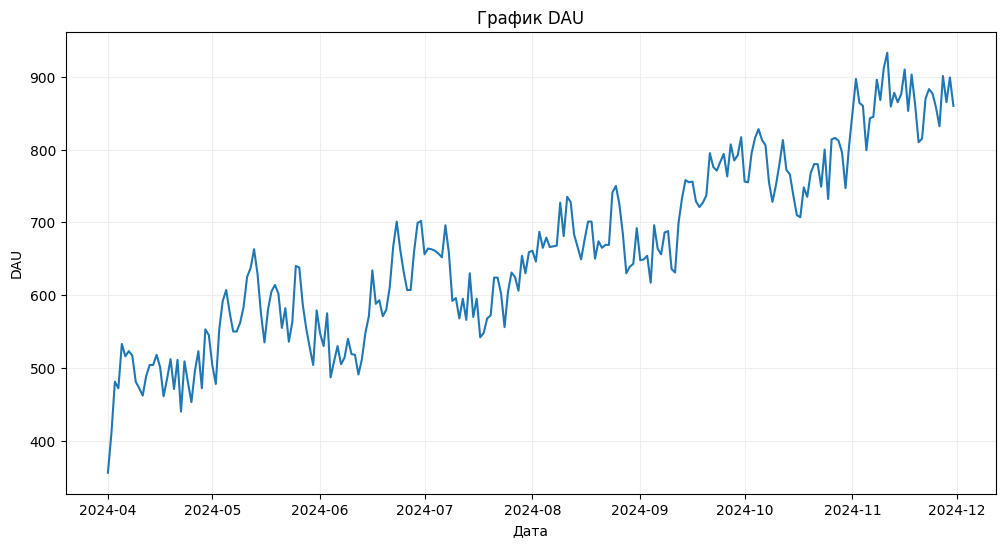

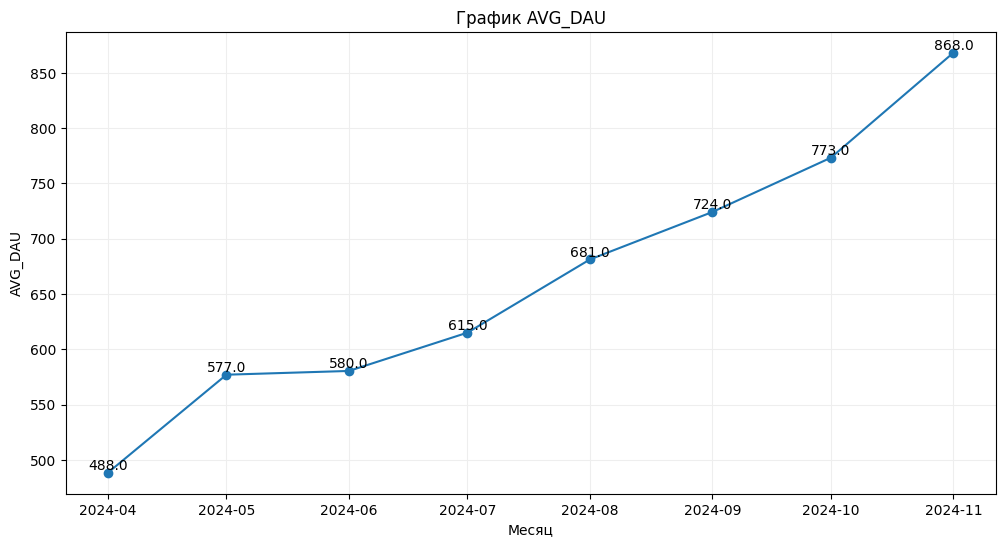

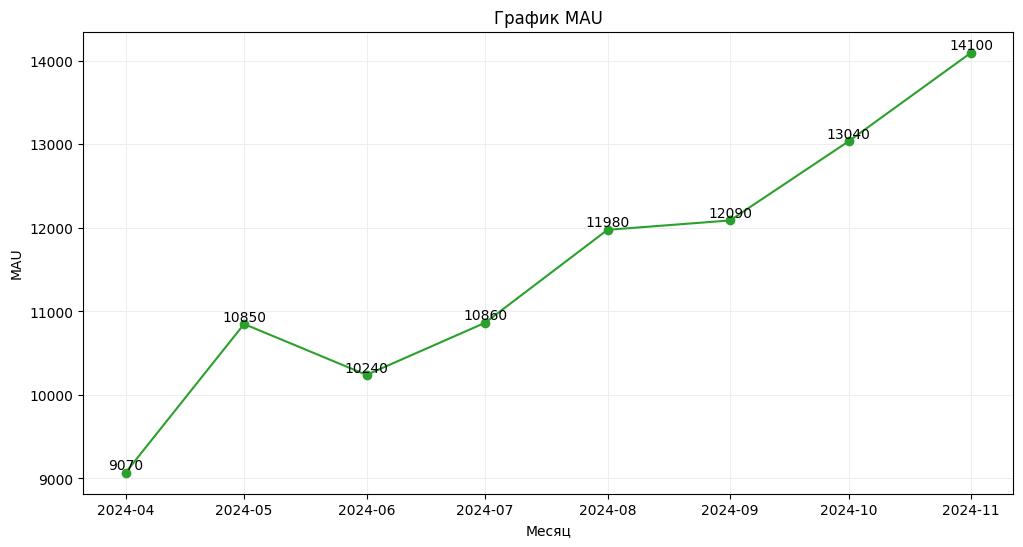

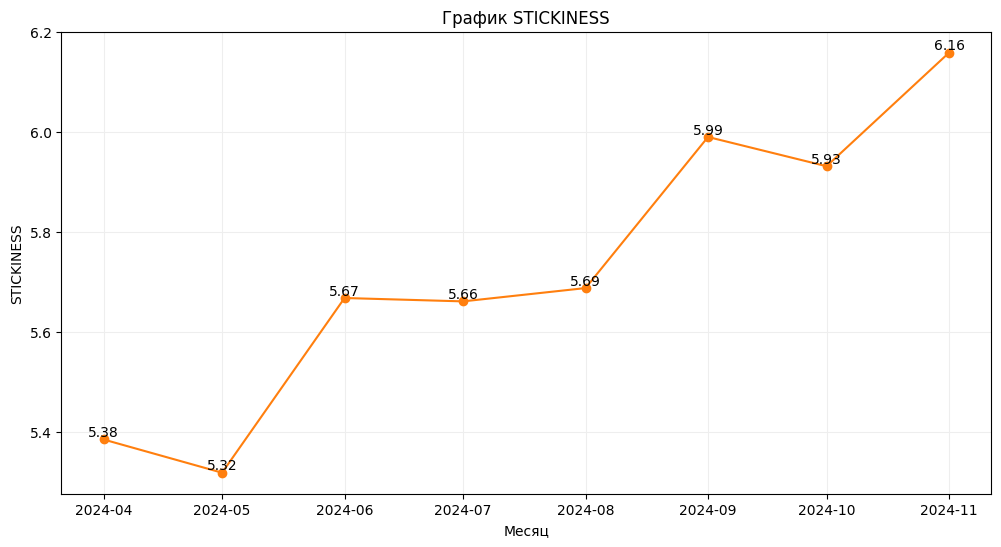

In [11]:
#  Добавляем дату и месяц сессии
visits['session_dt'] = visits['session_start'].dt.normalize()
visits['session_mon'] = visits['session_dt'].dt.to_period('M').dt.to_timestamp()

# ------------------------------------------------------------------------------
# ❗считаем СРЕДНЕМЕСЯЧНЫЙ DAU 
dau = visits.groupby('session_dt').agg(
    dau = ('user_id', 'nunique'),
    session_mon = ('session_mon', 'first')
).reset_index()

avg_dau = dau.groupby('session_mon')['dau'].mean().reset_index(name='avg_dau')
# ------------------------------------------------------------------------------
# считаем MAU 
mau = visits.groupby('session_mon')['user_id'].nunique()\
            .reset_index(name='mau')

# ------------------------------------------------------------------------------
# считаем stickiness
sticky = avg_dau.merge(mau, how='inner', on='session_mon')
sticky['stickiness'] = (sticky['avg_dau'] * 100/ sticky['mau'])#.round(2)

# ------------------------------------------------------------------------------
# строим графики

# DAU по дням
plt.figure(figsize=(12, 6))    
plt.plot(dau['session_dt'], dau['dau'])
plt.title(f'График DAU')
plt.xlabel('Дата')
plt.ylabel('DAU')
plt.grid(color='#eee')
plt.show()

# avg_dau, mau, stickiness
colors = ["#1f77b4", "#2ca02c", "#ff7f0e"]
acc = [0, -1, 2]
for i,met in enumerate(['avg_dau', 'mau', 'stickiness']):
    plt.figure(figsize=(12, 6))    
    plt.plot(sticky['session_mon'], sticky[met],marker='o', color=colors[i])
    
    for x_coord, y_coord in zip(sticky['session_mon'], sticky[met]):
        plt.text(x_coord, y_coord, f'{round(y_coord,acc[i])}',
                 ha='center', va='bottom')
        
    # Добавляем описание
    plt.title(f'График {met.upper()}')
    plt.xlabel('Месяц')
    plt.ylabel(met.upper())
    plt.grid(color='#eee')
    plt.show()

#### Среднемесячный DAU (AVG_DAU)
- на графике очетливо виден восходящий тренд на протяжении всего периода наблюдений
- количество активных пользователей в день меняется в диапазоне примерно от 490 в апреле 2024 года до 870 в ноябре 2024  
года
- сравнение метрики за май с июньским показателем и всеми последующими месяцами не дает возможности сделать однозначный  
вывод о влиянии нововведений сделанных в июне. **Для этого просто недостаточно предыстории.** Рост, начавшийся с июля  
это результат внедрения нововведений или часть долгосрочного многолетнего восходящего тренда? 
- Тем не менее, можно сделать вывод об **общей** положительной динамике метрики DAU


#### MAU
- на графике также наблюдается восходящий тренд на протяжении всего периода наблюдений
- количество активных пользователей в месяц меняется в диапазоне примерно от 9 тыс в апреле 2024 года до 14 тыс в ноябре  
2024 года 
- единственная небольшая просадка примерно на 5.6% наблюдается в июне - **именно в это время ("начало лета") в приложении**  
**появился новый вид контента — спортивный**
- **о динамике МAU можно также сделать положительный вывод - никаких аномалий. Метрика ведет себя очень стабильно** 

#### Stickiness
- метрика также растет весь период наблюдений. 
- диапазон изменений составляет от 5.2% до 6.2%, что в составляет прирост примерно на 14.5%.
- **внедрение нового вида контента и изменения маркетинговой стратегии в июне привели к существенному росту**
- `Stickiness` вырос с 5.32% в мае до 5.67% в июне, что составляет прирост на 6.6%

### 3.2. Анализ юнит-экономики по месячным когортам (период 28 дней)

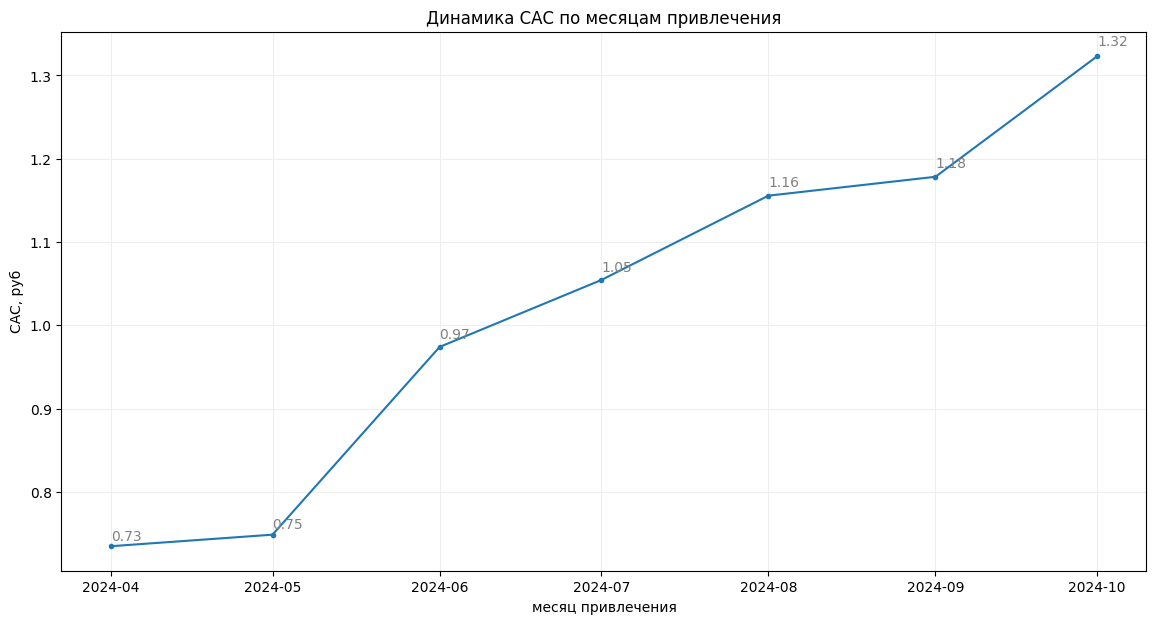

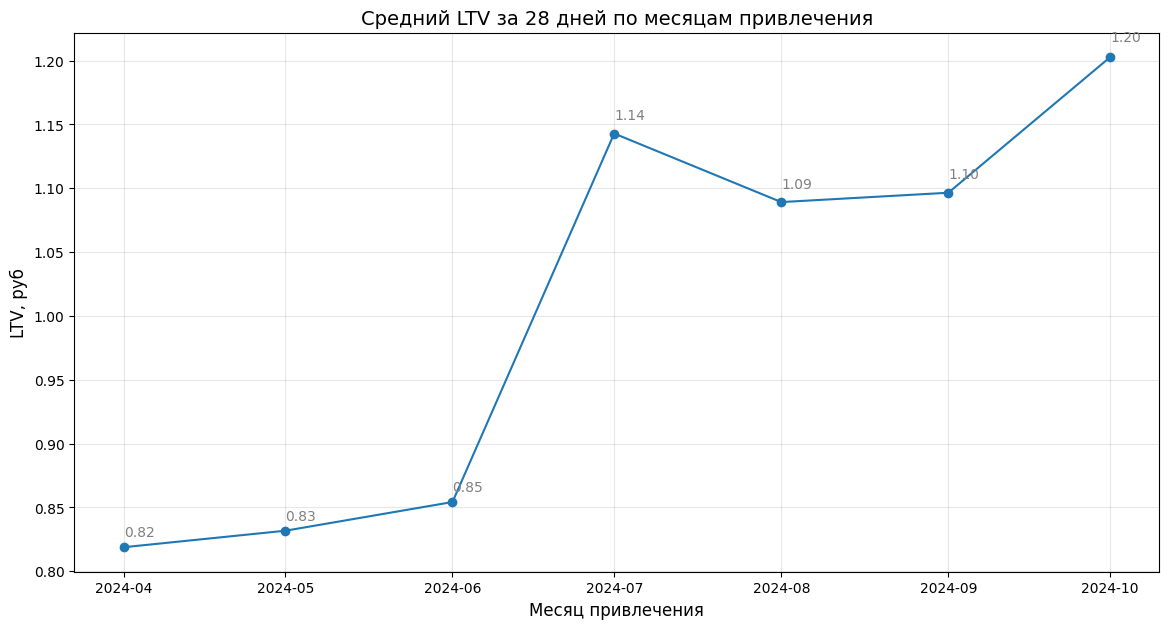

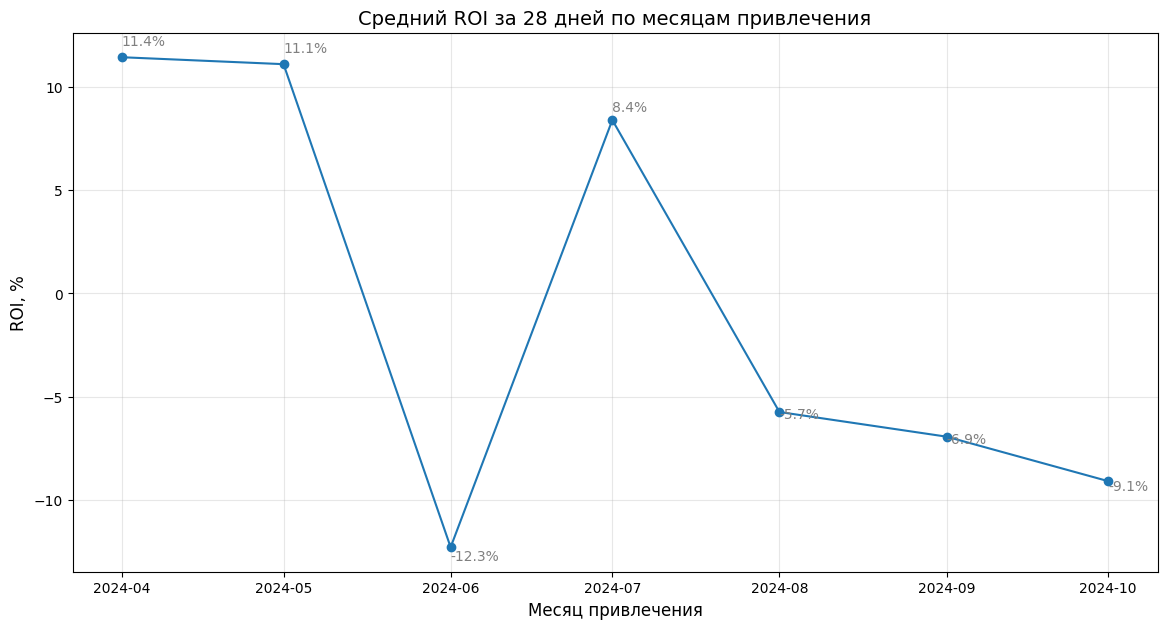

In [12]:
# расчет CAC 
# profiles['first_month'] = profiles['first_dt'].dt.to_period('M')\
#                                               .dt.to_timestamp()

# cac_mon = profiles.groupby('first_month').agg(
#     total_cost=('CAC', 'sum'),
#     cohort_size=('user_id', 'nunique')
# ).reset_index()

# cac_mon['CAC'] = cac_mon['total_cost'] / cac_mon['cohort_size']

# ------------------------------------------------------------------------------
# расчет CAC
profiles['first_month'] = profiles['first_dt'].dt.to_period('M')\
                                              .dt.to_timestamp()

# Считаем число новых пользователей в месяц
cohort_size = profiles.groupby(['first_month'])['user_id'].nunique()\
            .reset_index(name='cohort_size')

# считаем расходы на привлечение в месяц
costs['first_month'] = costs['dt'].dt.to_period('M').dt.to_timestamp()
cohort_costs = costs.groupby(['first_month'])['costs'].sum()\
            .reset_index(name='cohort_costs')


# Объединяем с costs 
cac_mon = cohort_size.merge(
    cohort_costs,
    on=['first_month'],
    how='left'
)[['first_month', 'cohort_size', 'cohort_costs']]

# Считаем CAC
cac_mon['CAC'] = (cac_mon['cohort_costs'] / cac_mon['cohort_size'])

    
# ------------------------------------------------------------------------------
# расчет LTV

# создаем базовую когорту с month
base_cohort = profiles[['user_id', 'first_month']].copy()

# оставляем покупки за 28 дней
orders_28 = orders[orders['n_day'].between(0, 27)].copy()

# ❗cчитаем выручку ТОЛЬКО по реальным покупкам 
revenue_agg = orders_28.groupby(['user_id', 'n_day'])['revenue'].sum()\
                .reset_index()

# объединяем
ltv_base = base_cohort.merge(revenue_agg, on='user_id', how='left')

# группируем 
rev_daily = ltv_base.groupby(['first_month', 'n_day'])['revenue'].sum()\
            .reset_index(name='total_revenue')

# накопленная выручка по когортам
rev_daily = rev_daily.sort_values(['first_month', 'n_day'])
rev_daily['cum_revenue'] = rev_daily.groupby('first_month')['total_revenue']\
                            .cumsum()

# объединяем с размером когорт
merged = rev_daily.merge(
    cac_mon[['first_month', 'cohort_size', 'CAC']], 
    on='first_month'
)

merged['LTV'] = merged['cum_revenue'] / merged['cohort_size']

# ------------------------------------------------------------------------------
# расчет ROI
merged['ROI'] = (merged['LTV'] - merged['CAC']) * 100 / merged['CAC']

# ------------------------------------------------------------------------------
# визуализаци
# выборочные когорты (несколько до и несколько после нововведений)
cohorts_colors = {
    '2024-04-01': '#1f77b4',
    '2024-05-01': '#ff7f0e',
    '2024-06-01': '#2ca02c',
    '2024-07-01': '#d62728',
    '2024-08-01': '#9467bd'
}

# ------------------------------------------------------------------------------
# Динамика CAС по месяцам привлечения
plt.figure(figsize=(14,7))
# Оставляем данные за 28 день (можно взять любой день - CAC везде одинаковый)
data_28 = merged[(merged['n_day'] == 27) & 
                 (merged['first_month']<'2024-11-01')].copy()
data_28 = data_28.sort_values('first_month')

plt.plot(data_28['first_month'], data_28['CAC'], marker='o', markersize=3)
# значения в точках
for x, y in zip(data_28['first_month'], data_28['CAC']):
    plt.text(x, y*1.01, f'{y:.2f}',  color='grey')
    
plt.title('Динамика CAС по месяцам привлечения')
plt.xlabel('месяц привлечения')
plt.ylabel('CAC, руб')
plt.grid(color='#eee')
plt.show()

# ------------------------------------------------------------------------------
# 'Средний LTV за 28 дней на одного пользователя в разрезе месяца привлечения'

# строим график
plt.figure(figsize=(14, 7))
plt.plot(data_28['first_month'], data_28['LTV'], marker='o', linestyle='-')

plt.title('Средний LTV за 28 дней по месяцам привлечения', fontsize=14)
plt.xlabel('Месяц привлечения', fontsize=12)
plt.ylabel('LTV, руб', fontsize=12)
plt.grid(alpha=0.3)

# подписи значений
for x, y in zip(data_28['first_month'], data_28['LTV']):
    plt.text(x, y*1.01, f'{y:.2f}', color='grey', fontsize=10)
    
    
# ------------------------------------------------------------------------------
# 'Средний ROI за 28 дней на одного пользователя в разрезе месяца привлечения'

# строим график
plt.figure(figsize=(14, 7))
plt.plot(data_28['first_month'], data_28['ROI'], marker='o', linestyle='-')

plt.title('Средний ROI за 28 дней по месяцам привлечения', fontsize=14)
plt.xlabel('Месяц привлечения', fontsize=12)
plt.ylabel('ROI, %', fontsize=12)
plt.grid(alpha=0.3)

# подписи значений
for x, y in zip(data_28['first_month'], data_28['ROI']):
    plt.text(x, y*1.05, f'{y:.1f}%', color='grey', fontsize=10)


#### CAC
- виден резкий рост CAC сразу после внедрения нового контента и изменения маркетинговой стартегии и во все остальные  
месяцы
- Метрика выросла на 76% - с 0.75 до 1.32

#### LTV
- резкий рост в июле (с опозданием от CAC на месяц) на 34% - с 0.85 до 1.14
- дальнейшая динамика не очень "выразительная" - небольшое снижение (около 5%) и затем небольшой рост 
  
#### ROI
- в результате того, что CAC рос быстрее LTV после внедрения изменений ROI стремительно упал с +11% в мае до -12% в июне.
- попытка восстановления в июле оказалась временной и уже в августе метрика вернулся в область отрицательных значений и  
продолжила снижение хотя уже и не так быстро


**Окупаемость когорт после внедрения изменений резко упала. Когорты больше не окупаются, по крайней мере за 28 дней.**

## 4. Анализ в разрезе маркетинговых каналов

### 4.1. Анализ объемов привлечения по каналам

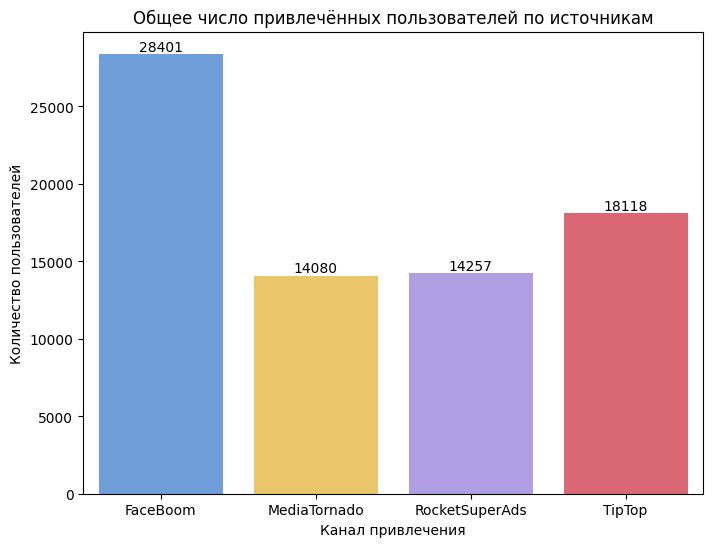

In [13]:
# Расчет общего числа пользователей по источникам
total_users = profiles.groupby('first_channel')['user_id'].nunique()\
                .reset_index(name='total_users')

# Визуализация
palette = ['#5D9CEC', '#FFCE54', '#AC92EC', '#ED5565']

plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=total_users,
    x='first_channel',
    y='total_users',
    hue='first_channel',
    palette=palette
)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Общее число привлечённых пользователей по источникам')
plt.ylabel('Количество пользователей')
plt.xlabel('Канал привлечения')
plt.show()
# print(total_users)

- Больше всего пользователей у FaceBoom - **28401**. 
- Это почти в 2 раза больше чем у каждого из остальных каналов
- MediaTornado **14080** пользователей
- RocketSuperAds **14257** пользователей
- TipTop **18118** пользователей
- **FaceBoom и tiptop - лидеры по количеству привлеченных пользователей**

#### Динамика привлечения новых пользователей по каналам

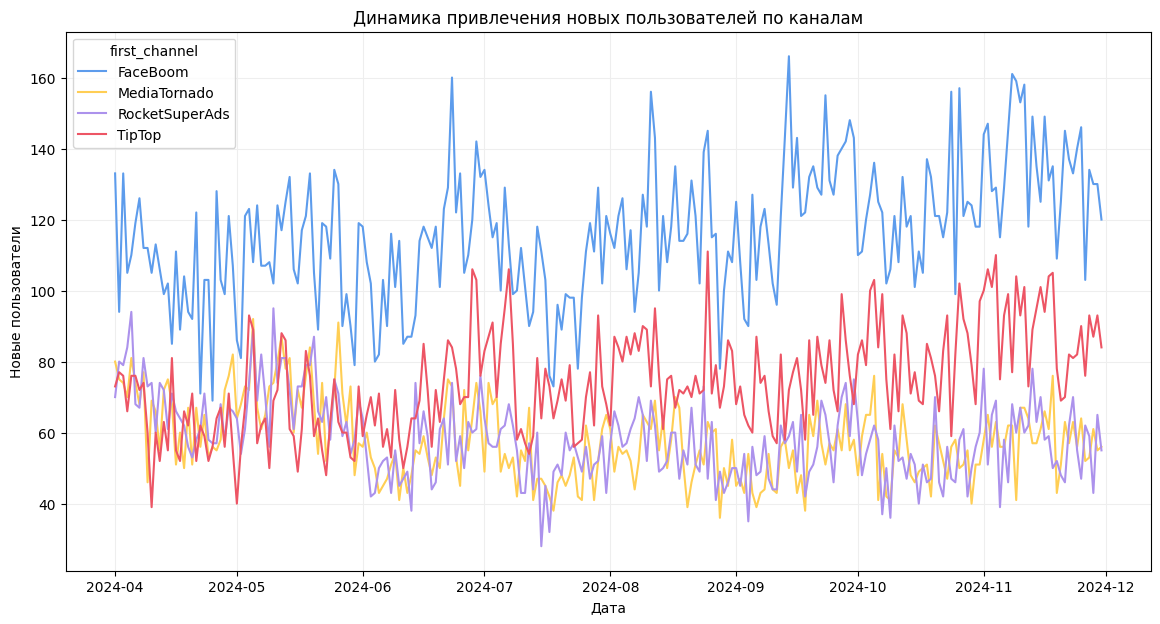

In [14]:
new_users = profiles.groupby(['first_dt', 'first_channel'])['user_id']\
                    .nunique().reset_index(name='new_users')

# Визуализация
plt.figure(figsize=(14,7))
sns.lineplot(
    data=new_users,
    x='first_dt',
    y='new_users',
    hue='first_channel',
    palette=palette
)


plt.title('Динамика привлечения новых пользователей по каналам')
plt.xlabel('Дата')
plt.ylabel('Новые пользователи')
plt.grid(color='#eee')
plt.show()


- Как видно из графика метрика очень вариативна по всем каналам и при этом нет ярко выраженного трендового движения. 
- Средние значения количества новых привлекаемых пользователей почти не меняются.
- В каналах **FaceBoom** и **tiptop** есть очень небольшой восходящий тренд примерно с середины лета (июль).
- Средние значения метрики каналов **FaceBoom** и **tiptop** ожидаемо находятся выше.
- В них также наблюдается чуть большая вариативность.
- **В целом, можно сделать вывод, о том что метрика ведет себя относительно стабильно по всем каналам в долгосрочной**  
**перспективе.**

### 4.2. Анализ метрик вовлеченности по каналам

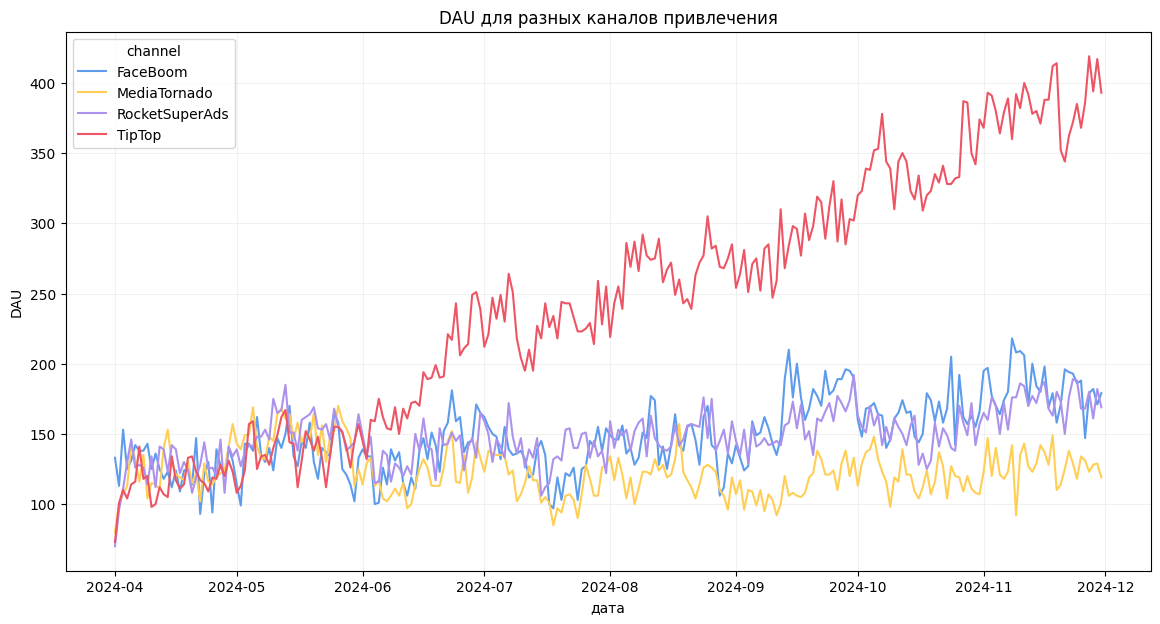

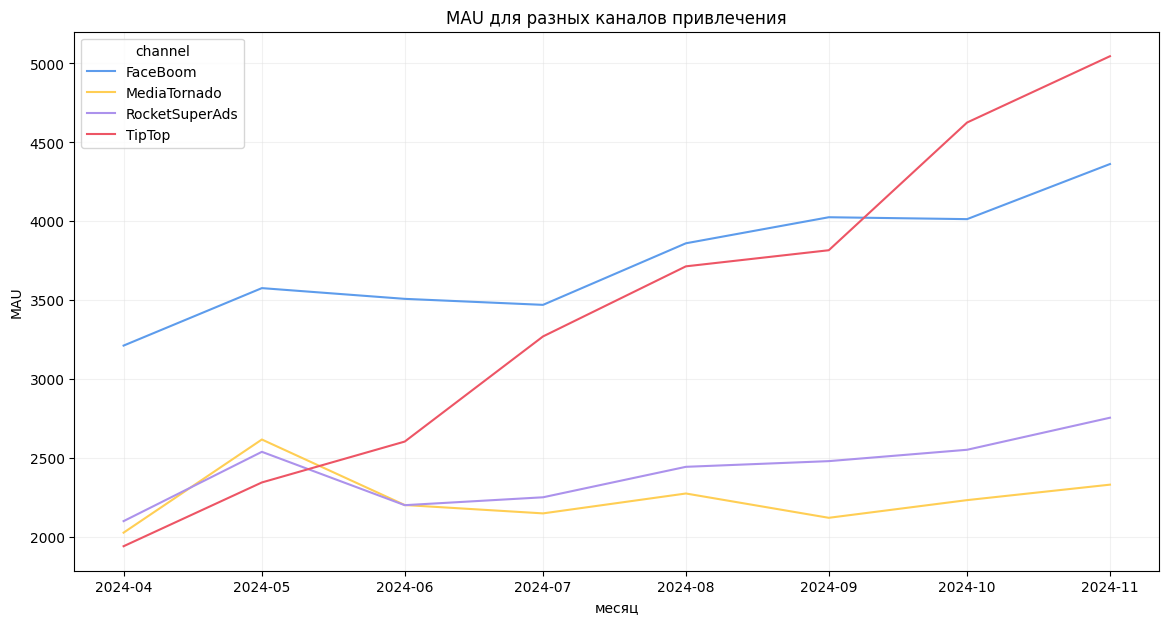

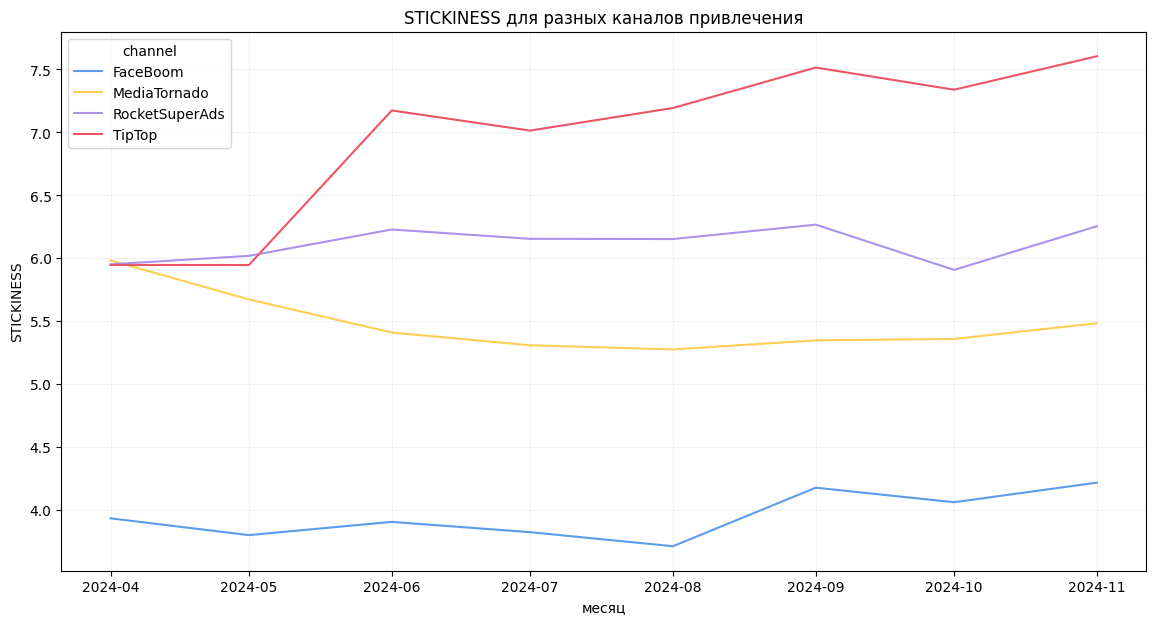

In [15]:
#  Добавляем дату и месяц сессии
visits['session_dt'] = visits['session_start'].dt.normalize()
visits['session_mon'] = visits['session_dt'].dt.to_period('M').dt.to_timestamp()

# ------------------------------------------------------------------------------
# считаем DAU по посещениям
dau = visits.groupby(['session_dt', 'channel']).agg(
    dau = ('user_id', 'nunique'),
    session_mon = ('session_mon', 'first')
).reset_index()

# ------------------------------------------------------------------------------
# считаем MAU по посещениям
mau = visits.groupby(['session_mon', 'channel']).agg(
    mau = ('user_id', 'nunique')
    # session_mon = ('session_mon', 'first')
).reset_index()

# ------------------------------------------------------------------------------
# считаем stickiness

# считаем среднемесячный DAU 
avg_dau = dau.groupby(['session_mon', 'channel'])['dau'].mean().reset_index(name='avg_dau')

merged = avg_dau.merge(mau, how='inner', on=['session_mon', 'channel'])
merged['stickiness'] = (merged['avg_dau'] * 100/ merged['mau'])#.round(2)

# ------------------------------------------------------------------------------
# строим визуализации
for met in ['dau', 'mau', 'stickiness']:
    # задаем размеры
    plt.figure(figsize=(14,7))
    
    # для DAU другой период и источник данных 
    period = 'session_dt' if met == 'dau' else 'session_mon'
    data = dau if met == 'dau' else merged
    
    
    sns.lineplot(
        data= data,
        x= period,
        y= met,
        # marker='o',
        hue='channel',
        palette=palette 
    )
    
    # Заголовок и подписи
    plt.title(f'{met.upper()} для разных каналов привлечения')
    plt.xlabel('дата' if met == 'dau' else 'месяц')
    plt.ylabel(f'{met.upper()}')
    plt.grid(alpha=.4)
    plt.grid(color='#ddd')
    plt.show()


#### DAU
- видно что внедрение нового контента драматично повлияло на метрику в канале **tiptop** - сильный ростовой тренд. К  
ноябрю DAU достиг средних значений около 380, что почти в 3 раза больше чем в апреле и мае (среднее около 130)
- в остальных каналах практически без изменений. *Относительно* небольшой рост (130->170) средних значений DAU в  
**FaceBoom** и  **RocketSuperAds**.

#### MAU
- те же выводы что и для DAU
- **tiptop** - драматичный рост примерно в 2.5 раза
- **FaceBoom** и **RocketSuperAds** - *относительно* небольшой рост 
- **MediaTorando** - практически без изменений
- ключевое отличие в том что MAU у **FaceBoom** в среднем почти раза в 1.5 выше чем у **RocketSuperAds** и  **MediaTorando**

#### Stickiness
- из-за особенности метрики MAU у **FaceBoom**,  вовлеченность этого канала получилась очень низкой. Количество активных  
пользователей высокое, но **высокие показатели обеспечиваются в основном, за счет большого притока новых пользователей**.  
Это может быть признаком привлечения **нецелевого трафика**.
- наиболее сильные показатели stickiness у **tiptop** и **RocketSuperAds**.
- у канала **tiptop** есть всплеск вовлеченности после внедрения нового контента и дальнейший небольшой ростовой  
тренд

**Внедрение нового контента оказало некоторое положительное влияние на stickiness канала **tiptop** , но результат**   
**сложно назвать впечатляющим. В остальных каналах без существенных изменений**

### 4.3. Анализ удержания и конверсии по каналам

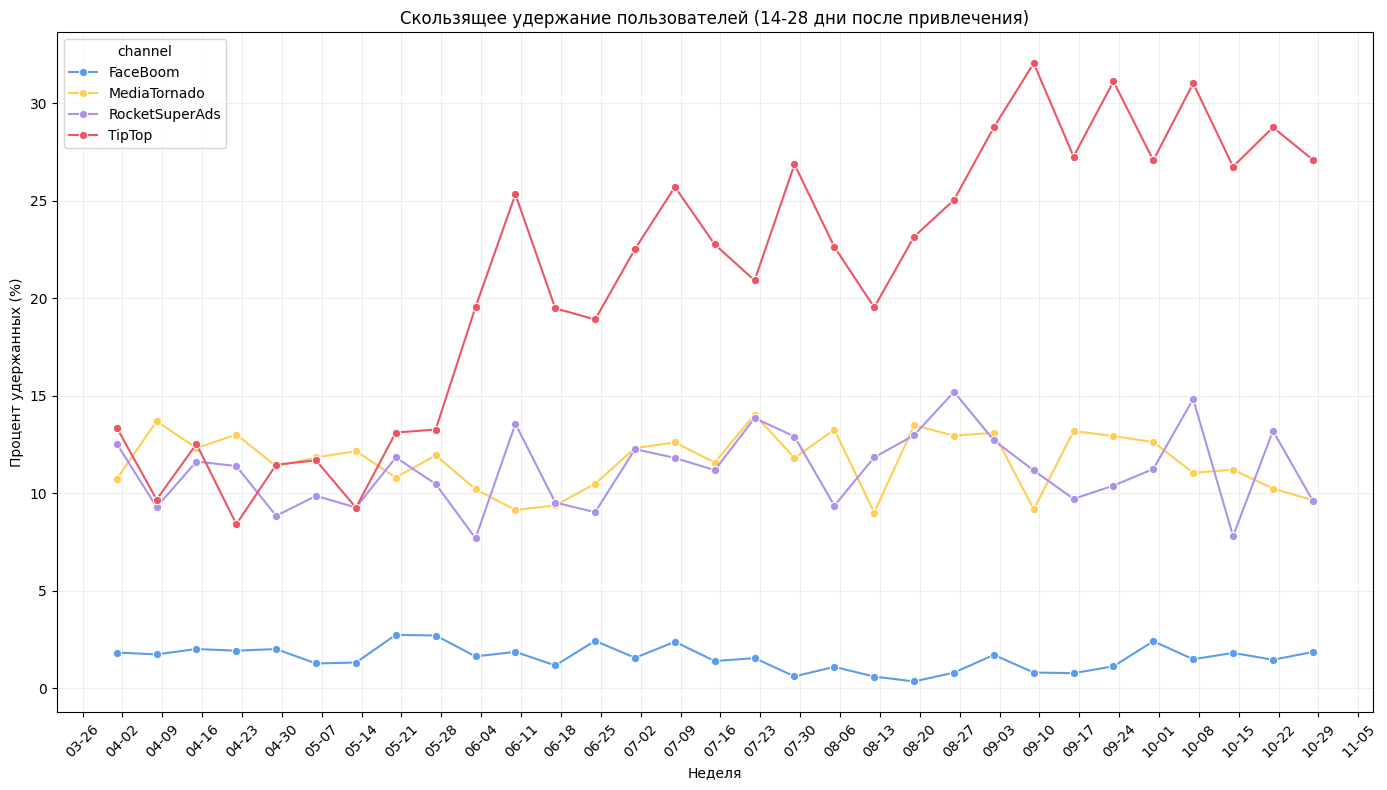

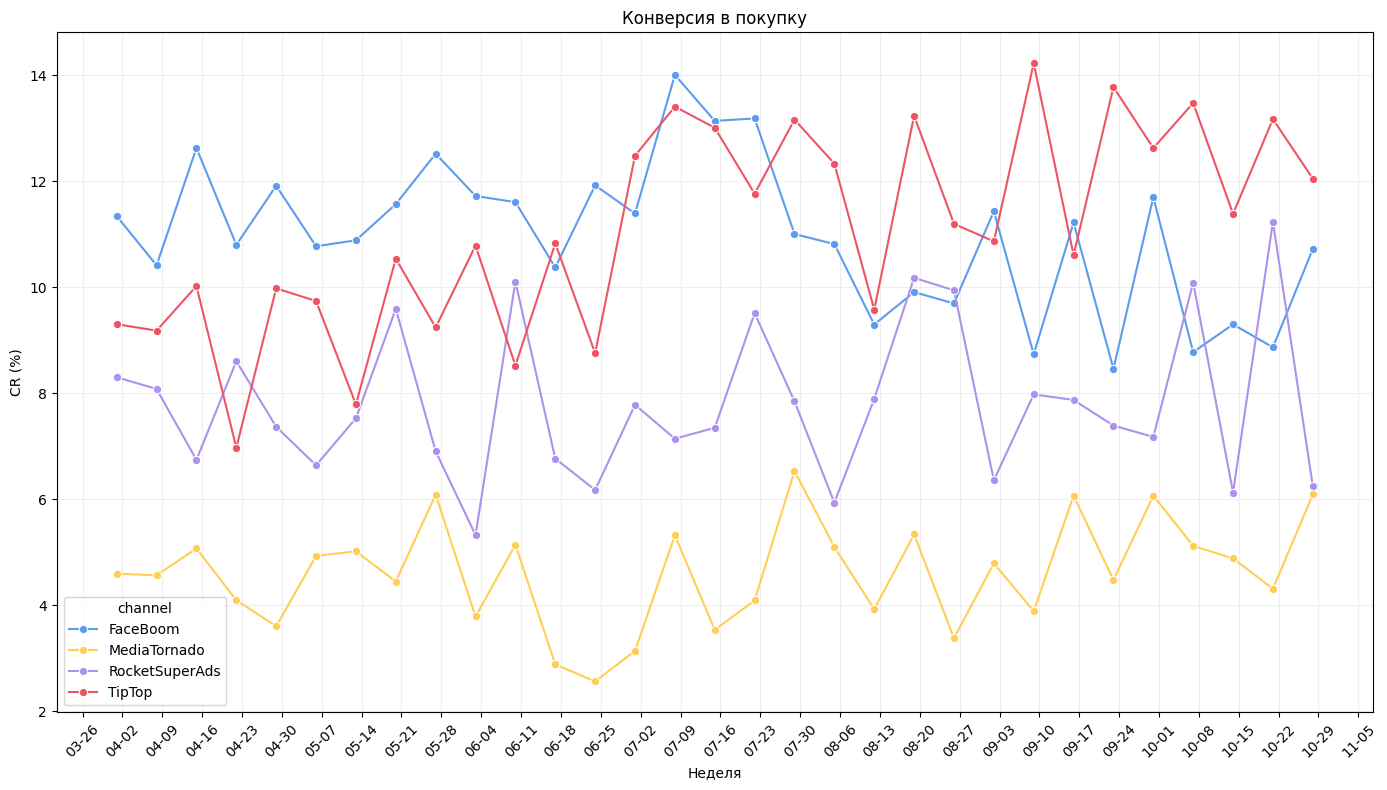

In [16]:
# СКОЛЬЗЯЩЕЕ УДЕРЖАНИЕ на 14-й день с момента привлечения (с 14-го по 28-й день)

# выделяем когорты
profiles['first_week'] = profiles['first_dt'].dt.to_period('W').dt.start_time
visits['first_week'] = visits['first_dt'].dt.to_period('W').dt.start_time
orders_28['first_week'] = orders_28['first_dt'].dt.to_period('W').dt.start_time


# фильтруем ноябрьские когорты
f_visits = visits[visits['first_dt'] < '2024-11-01'].copy()
f_profiles = profiles[profiles['first_dt'] < '2024-11-01'].copy()
f_orders_28 = orders_28[orders_28['first_dt'] < '2024-11-01'].copy()

# фильтруем по искомому диапазону
visits_14_28 = f_visits[(f_visits['n_day'].between(13, 27))]

# удержанные
retained = visits_14_28.groupby(['first_week', 'channel'])['user_id']\
            .nunique().reset_index(name='retained_users')

# размер когорты
cohort_size = f_profiles.groupby(['first_week', 'first_channel'])['user_id']\
            .nunique().reset_index(name='cohort_size')

# переименуем для удобства 
cohort_size.rename({'first_channel':'channel'}, inplace=True, axis=1)

# retention
rr = cohort_size.merge(retained, on=['first_week','channel'], how='left')
rr['retention'] = rr['retained_users'] * 100 / rr['cohort_size']
rr['retention'] = rr['retention'].fillna(0)

# сортируем
rr_sorted = rr.sort_values(['first_week', 'channel'])

# ------------------------------------------------------------------------------
# считаем КОНВЕРСИЮ В ПОКУПКУ

purchases = f_orders_28.groupby(['first_week','first_channel'])['user_id']\
            .nunique().reset_index(name='purchases')
# переименуем для удобства 
purchases.rename({'first_channel':'channel'}, inplace=True, axis=1)

# cr
purch = cohort_size.merge(purchases, on=['first_week','channel'], how='left')
purch['CR'] = purch['purchases'] * 100 / purch['cohort_size']
purch['CR'] = purch['CR'].fillna(0)

purch = purch.sort_values(['first_week', 'channel'])
# ------------------------------------------------------------------------------

# palette = ['#5D9CEC', '#FFCE54', '#AC92EC', '#ED5565']
# визуализация Retention и CR
metrics_descr = {
    'retention': [
        rr_sorted,
        'Скользящее удержание пользователей (14-28 дни после привлечения)',
        'Процент удержанных (%)'
    ],
    'CR' : [
        purch,
        'Конверсия в покупку',
        'CR (%)'
    ]
    
} 

for met, [data, title, ylabel] in metrics_descr.items(): 
    plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=data,
        x='first_week',
        y=met,
        hue='channel',
        marker="o",
        palette=palette,
    )

    # Настройка оформления
    plt.title(title)
    plt.xlabel('Неделя')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(color="#eee")

    # Улучшение отображения дат
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    plt.tight_layout()



#### Retention Rate
- Канал **tiptop**  показывает динамичный рост удержания с периодами стабилизации, начиания с когорты первой недели  
июня. Метрика растет с 9% - 13% до диапазона значений 20% - 25%, а затем и до 28% - 31% 
- Канал **FaceBoom** ожидаемо имеет очень низкое удержание (0.5% - 2.5%). Новые пользователи не задерживаются. Об этом  
говорилось выше.  
- Каналы **MediaTorando** и **RocketSuperAds** относительно стабильная динамика в диапазоне  7% - 15%.

#### CR
- Большая вариативность метрики во всем временном диапазоне по всем каналам
- Канал **tiptop** - ростовой тренд 
- Канал **FaceBoom** - снижение с середины лета (14% -> 9%)
- Канал **MediaTorando**  - боковой тренд в диапазоне 3-6.5%
- Канал **RocketSuperAds** - боковой тренд в диапазоне 6-9%

### 4.4. Анализ юнит-экономики по каналам (28 дней)

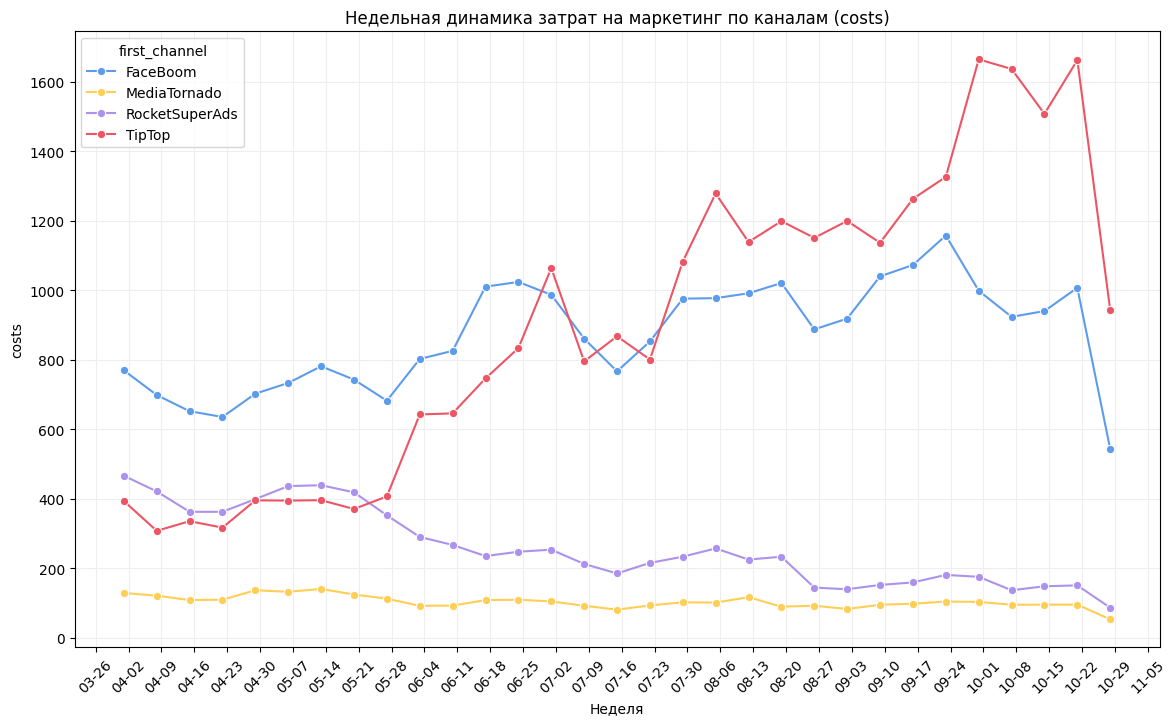

#### Недельная динамика затрат на маркетинг по каналам (costs)
- Канал **tiptop** - затраты выросли более чем в 4 раза (~400 → 1600+) с мая по ноябрь
- Канал **FaceBoom** - затраты стабильно высокие, с небольшим трендом на увеличение (~700 (май) → ~1000 (ноябрь))
- Канал **MediaTorando**  - затраты очень стабильны и почти не меняются (~125)
- Канал **RocketSuperAds** - снижение затрат с 400 до 170


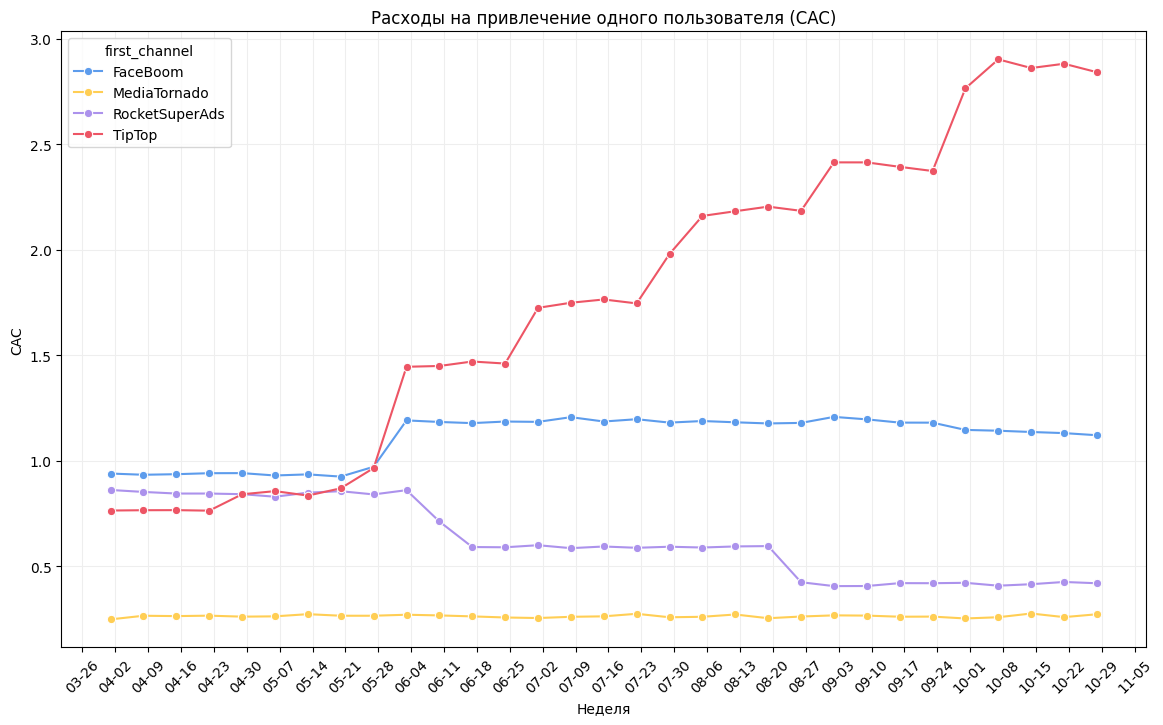

#### Расходы на привлечение одного пользователя (CAC)
- Форма графиков практически полностью совпадает с динамикой затрат на маркетинг, с той лишь разницей что CAC менее   
вариативен. Нет небольших локальных "провалов", которые в случае затрат на маркетинг, судя по всему, были обусловлены  
колебаниями количества привлеченных пользователей.  
- Канал **tiptop** - рост примерно в 3.5 раза (0.8 → 2.8)
- Канал **FaceBoom** - 2 области "полной стабильности"
    - ~0.95 до внедрения нового контента
    - 1.2 после внедрения нового контента
- Канал **MediaTorando**  - практически совсем не меняется - около 0.2
- Канал **RocketSuperAds** - 3 области "полной стабильности"
    - ~0.8 до внедрения нового контента
    - 0.6 после внедрения почти и до последней когорты августа (08-27) 
    - 0.4 начиная с последней когорты августа (08-27) и до конца периода наблюдений


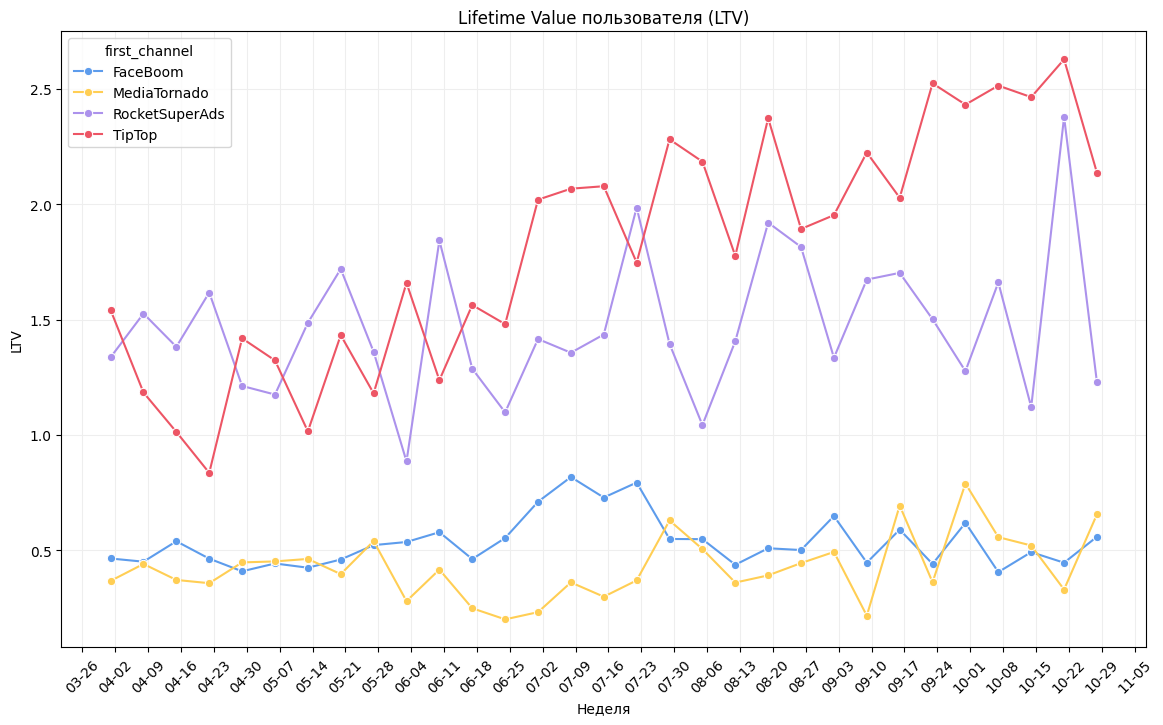

#### Lifetime Value пользователя (LTV)
- Канал **tiptop** - выраженный ростовой тренд до когорт ноября, затем стремительное падение, которое вероятно  
обусловлено неполнотой данных за последний месяц наблюдений
- Канал **RocketSuperAds** - схожая с каналом **tiptop** динамика, но существенно большая волатильность, на всем  
отрезке наблюдений
- Каналы **FaceBoom** и **MediaTorando** - безтрендовое движение с умеренной волатильностью и средним низким значением  
(в несколько раз ниже средних значений двух предыдущих каналов)


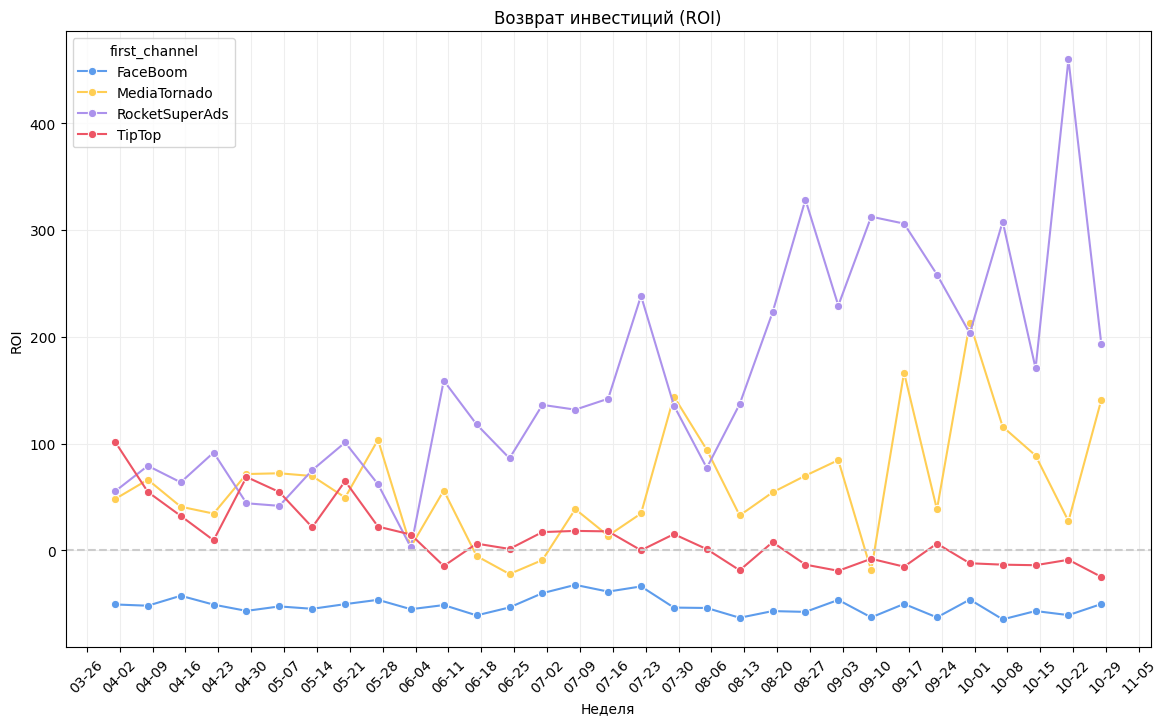

#### Возврат инвестиций (ROI)
- Все озвученные выше причины приводят к тому, что:
    - Канал **tiptop** после нововведений находится либо на грани окупаемости, либо (чаще всего) в небольшом убытке ~15%.
    - Канал **FaceBoom** очень сдержанно реагирует на изменения в контенте и маркетинге и очень стабилен в своей  
    убыточности на всем промежутке наблюдений - средние значиения лежат около -60%. Причина, как было озвучено выше,  
    скорее всего в нецелевом трафике и расходах на его привлечение.
- Канал **RocketSuperAds** - наиболее прибыльный. Все когорты в положительной зоне даже до нововведений. После  
внедрения изменений, метрика очень быстро растет и в пике достигает около 440%. Но в то же время присутствует очень  
большая волатильность, обусловленная "провалами" метрики LTV. Следует подумать над поиском возможных путей стабилизации  
LTV в этом канале. 
- Канал **MediaTorando** - схожая с каналом **RocketSuperAds** динамика, но более пологий восходящий тренд. Большинство  
когорт окупаются. Среднее значение около +70%


In [17]:
# Недельная динамика затрат и CAC
cac_weekly = f_profiles.groupby(['first_week', 'first_channel']).agg(
    costs=('CAC', 'sum'),
    cohort_size=('user_id', 'nunique')
).reset_index()
cac_weekly['CAC'] = cac_weekly['costs'] / cac_weekly['cohort_size']

# ------------------------------------------------------------------------------
# LTV
# выручка когорты
coh_rev = f_orders_28.groupby(['first_week', 'first_channel'])['revenue']\
        .sum().reset_index(name='cohort_revenue')

cac_weekly = cac_weekly[cac_weekly['first_week']< "2024-11-01"]
# объединяем чтобы получить cohort_size
roi = cac_weekly.merge(coh_rev, on=['first_week', 'first_channel'], how='left')
roi['LTV'] = roi['cohort_revenue'] / roi['cohort_size']

# ------------------------------------------------------------------------------
# ROI
roi['ROI'] = (roi['LTV'] - roi['CAC']) / roi['CAC'] * 100

# ------------------------------------------------------------------------------
# визуализация затрат на маркетинг, CAC, LTV, ROI

# описание метрик для построения графиков 
metrics_descr = {
    'costs': 'Недельная динамика затрат на маркетинг по каналам',
    # 'cohort_size': 'Колество пользователей в когорте',
    'CAC': 'Расходы на привлечение одного пользователя',
    'LTV': 'Lifetime Value пользователя',
    'ROI': 'Возврат инвестиций'
} 

# выводы по графикам
conclusion = {

'costs': 
f"""#### Недельная динамика затрат на маркетинг по каналам (costs)
- Канал **tiptop** - затраты выросли более чем в 4 раза (~400 → 1600+) с мая по ноябрь
- Канал **FaceBoom** - затраты стабильно высокие, с небольшим трендом на увеличение (~700 (май) → ~1000 (ноябрь))
- Канал **MediaTorando**  - затраты очень стабильны и почти не меняются (~125)
- Канал **RocketSuperAds** - снижение затрат с 400 до 170
""",

'CAC': 
f"""#### Расходы на привлечение одного пользователя (CAC)
- Форма графиков практически полностью совпадает с динамикой затрат на маркетинг, с той лишь разницей что CAC менее   
вариативен. Нет небольших локальных "провалов", которые в случае затрат на маркетинг, судя по всему, были обусловлены  
колебаниями количества привлеченных пользователей.  
- Канал **tiptop** - рост примерно в 3.5 раза (0.8 → 2.8)
- Канал **FaceBoom** - 2 области "полной стабильности"
    - ~0.95 до внедрения нового контента
    - 1.2 после внедрения нового контента
- Канал **MediaTorando**  - практически совсем не меняется - около 0.2
- Канал **RocketSuperAds** - 3 области "полной стабильности"
    - ~0.8 до внедрения нового контента
    - 0.6 после внедрения почти и до последней когорты августа (08-27) 
    - 0.4 начиная с последней когорты августа (08-27) и до конца периода наблюдений
""",

'LTV': 
f"""#### Lifetime Value пользователя (LTV)
- Канал **tiptop** - выраженный ростовой тренд до когорт ноября, затем стремительное падение, которое вероятно  
обусловлено неполнотой данных за последний месяц наблюдений
- Канал **RocketSuperAds** - схожая с каналом **tiptop** динамика, но существенно большая волатильность, на всем  
отрезке наблюдений
- Каналы **FaceBoom** и **MediaTorando** - безтрендовое движение с умеренной волатильностью и средним низким значением  
(в несколько раз ниже средних значений двух предыдущих каналов)
""",

'ROI': 
f"""#### Возврат инвестиций (ROI)
- Все озвученные выше причины приводят к тому, что:
    - Канал **tiptop** после нововведений находится либо на грани окупаемости, либо (чаще всего) в небольшом убытке ~15%.
    - Канал **FaceBoom** очень сдержанно реагирует на изменения в контенте и маркетинге и очень стабилен в своей  
    убыточности на всем промежутке наблюдений - средние значиения лежат около -60%. Причина, как было озвучено выше,  
    скорее всего в нецелевом трафике и расходах на его привлечение.
- Канал **RocketSuperAds** - наиболее прибыльный. Все когорты в положительной зоне даже до нововведений. После  
внедрения изменений, метрика очень быстро растет и в пике достигает около 440%. Но в то же время присутствует очень  
большая волатильность, обусловленная "провалами" метрики LTV. Следует подумать над поиском возможных путей стабилизации  
LTV в этом канале. 
- Канал **MediaTorando** - схожая с каналом **RocketSuperAds** динамика, но более пологий восходящий тренд. Большинство  
когорт окупаются. Среднее значение около +70%
"""     
}

for met, title in metrics_descr.items(): 
    plt.figure(figsize=(14, 8))
    ax = sns.lineplot(
        data=roi,
        x='first_week',
        y=met,
        hue='first_channel',
        marker="o",
        palette=palette,
    )

    # линия безубыточности (0)
    (met == 'ROI') and plt.axhline(0,ls='--', color='#ccc', label='payback')
    
    # Настройка оформления
    plt.title(f'{title} ({met})')
    plt.xlabel('Неделя')
    plt.ylabel(met)
    plt.xticks(rotation=45)
    plt.grid(color="#eee")

    # Улучшение отображения дат
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # plt.tight_layout()
    plt.show()
    
    # печатаем вывод 
    display(Markdown(conclusion[met]))



## 5. Анализ периода окупаемости для убыточных каналов

#### Расчет 10-недельного ROI каналов FaceBoom и TipTop, которые не окупились за 28 дней

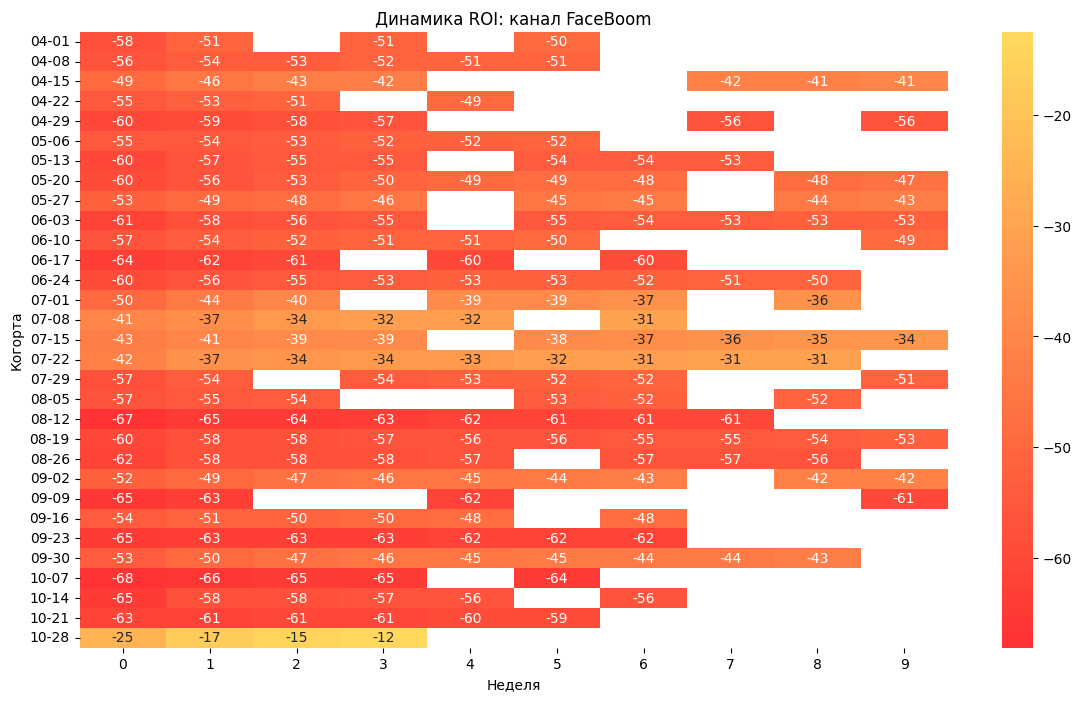

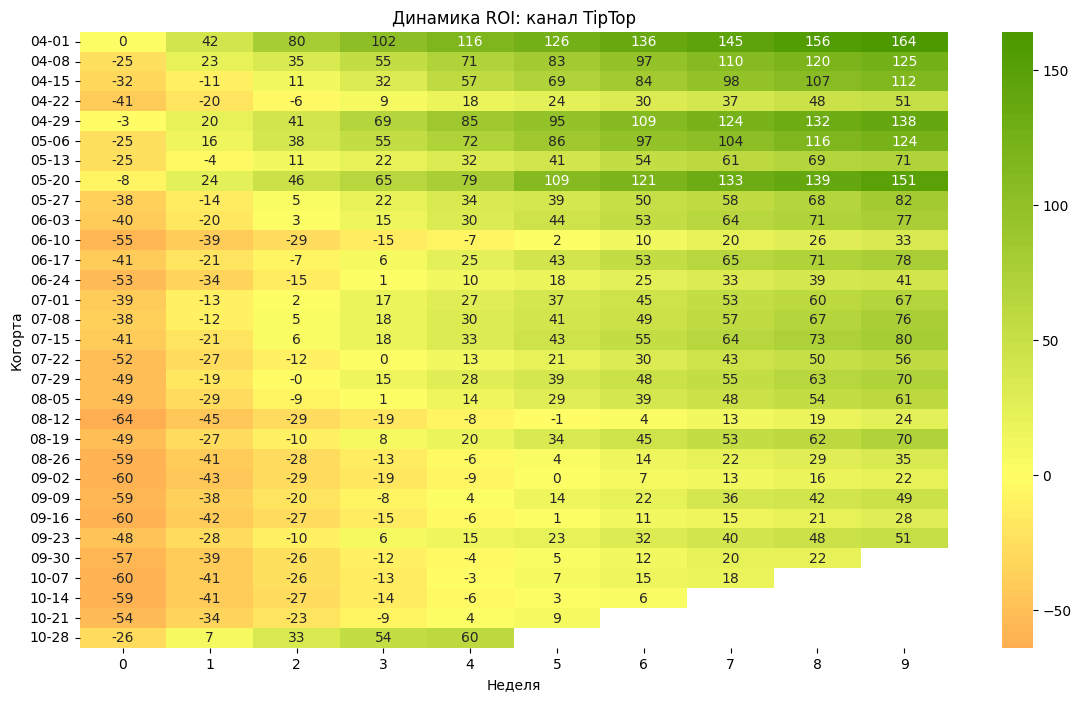

In [18]:
# Заказы за 70 дней (10 недель)
orders_70 = orders[orders['n_day'] < 70].copy()

# выделяем недельные когорты
orders_70['first_week'] = orders_70['first_dt'].dt.to_period('W').dt.start_time

# считаем номер недели
orders_70['n_week'] = (orders_70['event_dt'] - orders_70['first_dt'])\
                    .dt.days // 7

# ------------------------------------------------------------------------------
# LTV 
# выручка когорты
coh_rev = orders_70.groupby(['first_week', 'first_channel', 'n_week'])\
            ['revenue'].sum().reset_index()

# накопленная выручка
coh_rev['cum_rev'] = coh_rev.groupby(['first_week', 'first_channel'])\
            ['revenue'].cumsum()

# объединяем чтобы получить размер когорты
unique_weeks = coh_rev['n_week'].unique()
cac_exp = pd.merge(
    cac_weekly.assign(key=1),
    pd.DataFrame({'n_week': unique_weeks, 'key': 1}),
    on='key'
).drop('key', axis=1)

roi = cac_exp.merge(coh_rev, on=['first_week', 'first_channel', 'n_week'], how='left')
roi['LTV'] = roi['cum_rev'] / roi['cohort_size']
# roi['LTV'] = roi['LTV'].fillna(0.)
roi['CAC'] = roi['CAC'].fillna(0.)

# ------------------------------------------------------------------------------
# ROI
roi['ROI'] = (roi['LTV'] - roi['CAC'])*100 / roi['CAC'] 

# ------------------------------------------------------------------------------
# визуализация затрат на маркетинг, CAC, LTV, ROI
# ТЕПЛОВАЯ КАРТА
cmap = mcolors.LinearSegmentedColormap.from_list(
    'green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

unique_weeks = coh_rev['n_week'].unique()

# строим графики
for channel in ['FaceBoom', 'TipTop']:
    # размер графика
    plt.figure(figsize=(14, 8)) 
    
    roi_pivot = roi[roi['first_channel']==channel]
    roi_pivot = roi_pivot.pivot(
        index='first_week',
        columns='n_week',
        values='ROI'
    )
    
    # форматируем названия когорт
    roi_pivot.index = roi_pivot.index.strftime('%m-%d')
    
    # Строим тепловую карту
    sns.heatmap(
        roi_pivot,
        annot=True,
        annot_kws={"size": 10},
        fmt='.0f',
        center=0, 
        cmap=cmap
    )
    
    # Добавляем подписи для осей и заголовок графика referral
    plt.title(f'Динамика ROI: канал {channel}')
    plt.xlabel('Неделя')
    plt.ylabel('Когорта')
    plt.show()
    # print(roi_pivot)

#### FaceBoom
- **канал совсем не окупается - даже после 10 недель с момента привлечения.** 
- ни одна когорта не преодолела даже порог (-)30%
- как мы видели выше этот канал обладает самым большим количеством привлеченных пользователей и при этом самой низкой   
вовлеченностью (stickiness) и удержанием. Наиболее вероятное объяснение в том, что большая часть трафика является  
нецелевым. 
- **бизнес только теряет деньги на этом канале.** 

#### TipTop
- **канал не самый доходный, но все же выходит в прибыль со временем.**
- большая часть когорт окупается к пятой неделе (пор. номер 4). Убыточых когорт к этому времени всего 9.
- на 6 неделе (пор. номер 5) убыточная когорта только одна. 
- таким образом **канал окупается за 6 недель, вместо 4 как ожидалось.** 
- бизнесу необходимо орпеделиться, является ли полученный результат удовлетворительным или требование "улучшить  
окупаемость до 4 недель" является обязательным. В этом случае, следует задуматся над возможностью минимизацией CAC  
и увеличения LTV, а также улучшением "качества" трафика, его удержанием и вовлеченностью контента.


## 6. Выводы и рекомендации

### Ключевые выводы

- **Причина стагнации выручки - дисбаланс в юнит-экономике.** После изменения маркетинговой стратегии рост стоимости  
привлечения (CAC: с 0.75 до 1.32, **+76%**) опередил рост LTV (LTV: с 0.85 до 1.14, **+34%**). Это привело к падению ROI  
с +11% до -12% и убыточности новых когорт. 

- **Канал FaceBoom - основной источник проблемы.** Несмотря на самый большой объем трафика (28 тыс. пользователей),  
канал стабильно убыточен (ROI ~ -60%). Причина - привлечение нецелевой аудитории, что подтверждается крайне низкой  
вовлеченностью (до 2.5%) и падением конверсии в покупку (с 14% до 9%). 

- **Канал TipTop - точка роста.** Этот канал показал максимальный рост после запуска нового контента (DAU вырос почти в   
3 раза) и значительное улучшение удержания (+200%). Однако срок его окупаемости увеличился с требуемых 4 до 6 недель из-  
за резкого роста CAC.  

- **RocketSuperAds и MediaTornado — стабильно прибыльные каналы.** Оба канала показывают стабильную окупаемость (ROI  
+440% и +70% соответственно) при умеренных объемах привлечения трафика.

### Рекомендации для отдела маркетинга  

1.  **Канал FaceBoom: Сократить и оптимизировать.**  
    -   **Сократить бюджет на 50%**, чтобы остановить рост убытков и повысить общую эффективность маркетинговых вложений.
    -   Провести аудит рекламных кампаний для выявления и отключения неэффективных сегментов.
    -   Высвободившиеся средства направить на масштабирование более прибыльных каналов.

2.  **Канал TipTop: Оптимизировать для роста.**
    -   Сфокусироваться на снижении CAC, чтобы вернуть окупаемость в рамки бизнес-модели (4 недели вместо 6).
    -   Учитывая высокий рост вовлеченности, этот канал является самым перспективным для дальнейшего масштабирования  
    **после** оптимизации затрат.

3.  **Общая стратегия: Сместить фокус на качество.**
    -   Перейти от цели "рост аудитории" к цели "рост прибыльной аудитории".
    -   Внедрить регулярный мониторинг юнит-экономики **по каждому каналу**, чтобы оперативно реагировать на подобные   
    дисбалансы в будущем.